# Importing modules

As any other ML project, we start by importing the modules we will use. In this case we'll use pandas, numpy, matplotlib, seaborn, and various Scikit-learn's modules.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Import Data

Next we import the wine dataset 

In [2]:
columnsWine = ["WineID", "Alcohol", "MalicAcid", "Ash", "AlcalinityOfAsh", "Magnesium", "TotalPhenols", 
               "Flavanoids", "NonflavanoidPhenols","Proanthocyanins", "ColorIntensity", "Hue", "OD280/OD315", "Proline"]

url = "https://raw.githubusercontent.com/crisb-7/Evidencia02-WineClassification/main/wine.data"
df = pd.read_csv(url, names = columnsWine)

In [3]:
df.head()

,WineID,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Preprocessing data for the Neural Network

We wish to standardize the input of the neural network to align with the Multi-layer Perceptron Classifier's output (MLPC). We apply a Min-Max scaling to our feature data and a Label Encoder to our wine categories.

In [4]:
le = LabelEncoder()
scaler = MinMaxScaler()

In [5]:
x = scaler.fit_transform(df.drop(columns = "WineID"))
y = le.fit_transform(df.WineID)

## PCA

We can also apply a Principal Component Analysis technique in order to reduce the dimensionality of the data. We wish to reduce 13 features or dimensions to 2 in order to visualize the decision boundary of the MLPC.

In [6]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# Train-validate-test split

We divide the dataset into 3 subsets: **train** (56%), **validate** (24%), and **test** (20%). We will also work with the same random state (0) for all Sklearn's functions for reproducibility.

In [7]:
rs, rsData = 0, 0
x1, x_test, y1, y_test = train_test_split(x_pca, y, train_size = 0.8, random_state = rsData)
x_train, x_validate, y_train, y_validate = train_test_split(x1, y1, train_size = 0.7, random_state = rsData)

# Randomized Search & Grid Search

Now we can perform a randomized search for the best hyperparameters of the NN with a fix set of epochs (200).

In [8]:
epochs = 200

In [9]:
hyperparameters = {'activation': ['relu', 'logistic', 'tanh'], 
                   'hidden_layer_sizes': [(2,), (4,), (8,), (16,), (64,), (100,), 
                                          (2,2,), (2,3), (3,2), (4,2), (2,4), (8,2), (2,8), (8,4), (4,8),
                                         (2,2,2), (4,2,2), (2,4,2), (4,2,4), (4,8,2), (4,8,4), (8,8,8)],
                   'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                   'learning_rate_init': [0.001, 0.005, 0.01, 0.05, 0.1],
                   'learning_rate': ['adaptive', 'constant'],
                   'solver': ['adam', 'sgd', 'lbfgs']}

In [10]:
nn = MLPClassifier(random_state = rs, max_iter = epochs)

hps = RandomizedSearchCV(nn, hyperparameters, n_iter = 200, n_jobs = -1, cv = 5)

hps.fit(x_train, y_train);

bestH = hps.best_params_

SearchResults = pd.DataFrame(hps.cv_results_)
SearchResults = SearchResults.drop(columns = ["mean_fit_time", "std_fit_time", 
                                              "mean_score_time", "std_score_time", "params"])
SearchResults = SearchResults.sort_values("rank_test_score", ascending = True)

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
SearchResults.head()

,param_solver,param_learning_rate_init,param_learning_rate,param_hidden_layer_sizes,param_alpha,param_activation,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,adam,0.005,constant,"(100,)",0.0001,logistic,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
72,adam,0.001,adaptive,"(100,)",0.01,tanh,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
172,adam,0.01,constant,"(4,)",0.005,tanh,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
153,sgd,0.01,constant,"(100,)",0.005,relu,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
43,adam,0.001,adaptive,"(64,)",0.01,tanh,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1


After this, we can proceed to make a more granular search near the best parameters found in through the randomized search.

In [12]:
hyperparameters = {'activation': ['relu', 'tanh', 'logistic'], 
                   'hidden_layer_sizes': [(64,)],
                   'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                   'learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
                   'learning_rate': ['adaptive'],
                   'solver': ['adam', 'sgd']}

In [13]:
nn = MLPClassifier(random_state = rs, max_iter = epochs)

hps = GridSearchCV(nn, hyperparameters, n_jobs = -1, cv = 5) 

hps.fit(x_train, y_train);

bestH = hps.best_params_

SearchResults = pd.DataFrame(hps.cv_results_)
SearchResults = SearchResults.drop(columns = ["mean_fit_time", "std_fit_time", 
                                              "mean_score_time", "std_score_time", "params"])
SearchResults = SearchResults.sort_values("rank_test_score", ascending = True)

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
SearchResults.head()

,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
209,logistic,0.01,"(64,)",adaptive,0.1,sgd,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
79,tanh,0.0001,"(64,)",adaptive,0.01,sgd,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
88,tanh,0.0005,"(64,)",adaptive,0.001,adam,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
65,relu,0.01,"(64,)",adaptive,0.01,sgd,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1
93,tanh,0.0005,"(64,)",adaptive,0.01,sgd,1.0,1.0,0.95,1.0,0.947368,0.979474,0.025153,1


We can now build our MLPC using these "optimized" hyperparameters.

# Model

Definining the model found in the previous section:

In [29]:
myNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (64,), learning_rate = "adaptive", 
                     solver="adam", activation = "logistic", alpha = 0.0001, 
                     learning_rate_init = 0.01, max_iter = epochs)

We run a partial fit with the set number of epochs and storing their respective scores each iteration.

In [30]:
train_score, validate_score, test_score = [], [], []

for i in range(0, epochs):
    
    myNN.partial_fit(x_train, y_train, np.unique(y_train))
    
    train_score.append(myNN.score(x_train, y_train))
    validate_score.append(myNN.score(x_validate, y_validate))
    test_score.append(myNN.score(x_test, y_test))

In [31]:
print("Training score: ", myNN.score(x_train, y_train))
print("Validate score: ", myNN.score(x_validate, y_validate))
print("Testing score: ", myNN.score(x_test, y_test))

Training score:  0.9797979797979798
Validate score:  0.9767441860465116
Testing score:  1.0


## Decision Boundary

Since the model's input consists of two orthogonal components, we can plot the datapoints over the colormap representing the decision of the classification by the MLPC. In this case we separate the 3 subsets (train, test, validate) in order to get more insight into the individual accuracy scores.

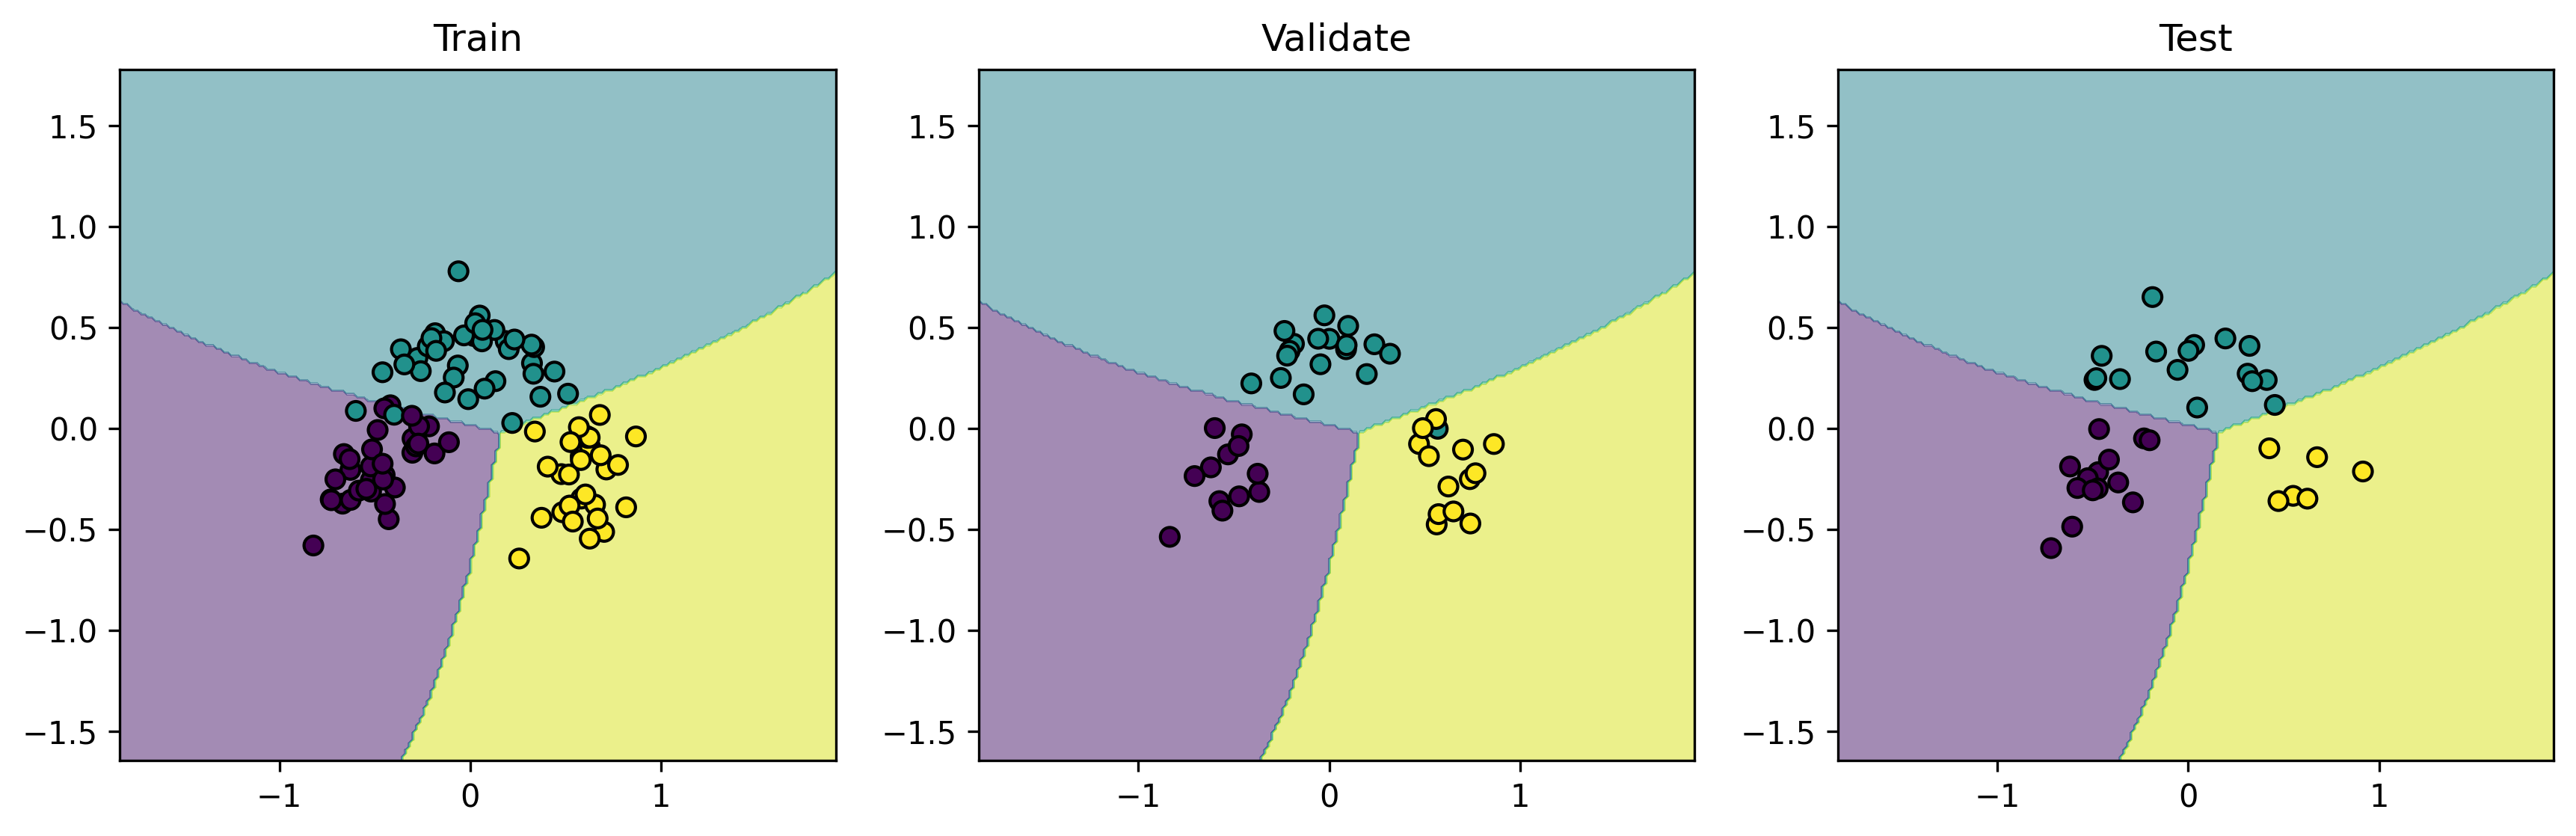

In [32]:
fig, axes = plt.subplots(1,3, figsize = (14,4))

DecisionBoundaryDisplay.from_estimator(myNN, x_pca, response_method="predict", alpha=0.5, grid_resolution=200, ax = axes[0])
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor="k")
axes[0].set_title("Train")

DecisionBoundaryDisplay.from_estimator(myNN, x_pca, response_method="predict", alpha=0.5, grid_resolution=200, ax = axes[1])
axes[1].scatter(x_validate[:, 0], x_validate[:, 1], c=y_validate, edgecolor="k")
axes[1].set_title("Validate")

DecisionBoundaryDisplay.from_estimator(myNN, x_pca, response_method="predict", alpha=0.5, grid_resolution=200, ax = axes[2])
axes[2].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolor="k")
axes[2].set_title("Test")

plt.show()

We can see that the boundary is reasonably smooth, almost linear. The data scaling along with the PCA yields relatively cluttered datapoints in a inverse U shape, however, there is a pretty clear division between classes. The MLPC correctly identifies these boundaries at the right angles (broadly). This indicates that even if the boundary by the MLPC represents a simple model, it can be said that the bias is low since the average accuracy on the 3 subsets is greater that 97%.

We can see that there are a few missclassified instances; nevertheless these instances seem to represent irreducible error due to noise given the considerable overlap between classes. This happens both in the training and validating sets but not on the test set, indicating that this might be a matter of random sampling, reinforcing the idea of irreducible error; the model would have to have an unreasonable level of adjustment in any of these sets in order to avoid this error (overfitting), and, even if it did, this over-adjusted model would not generalize very well to unseen data. Even with this noise, the model generalizes extremely well in both the validating and test set, so we can reasonably affirm that the model's variance is low. 

One can further plot the evolution of the accuracy on all sets and the loss function:

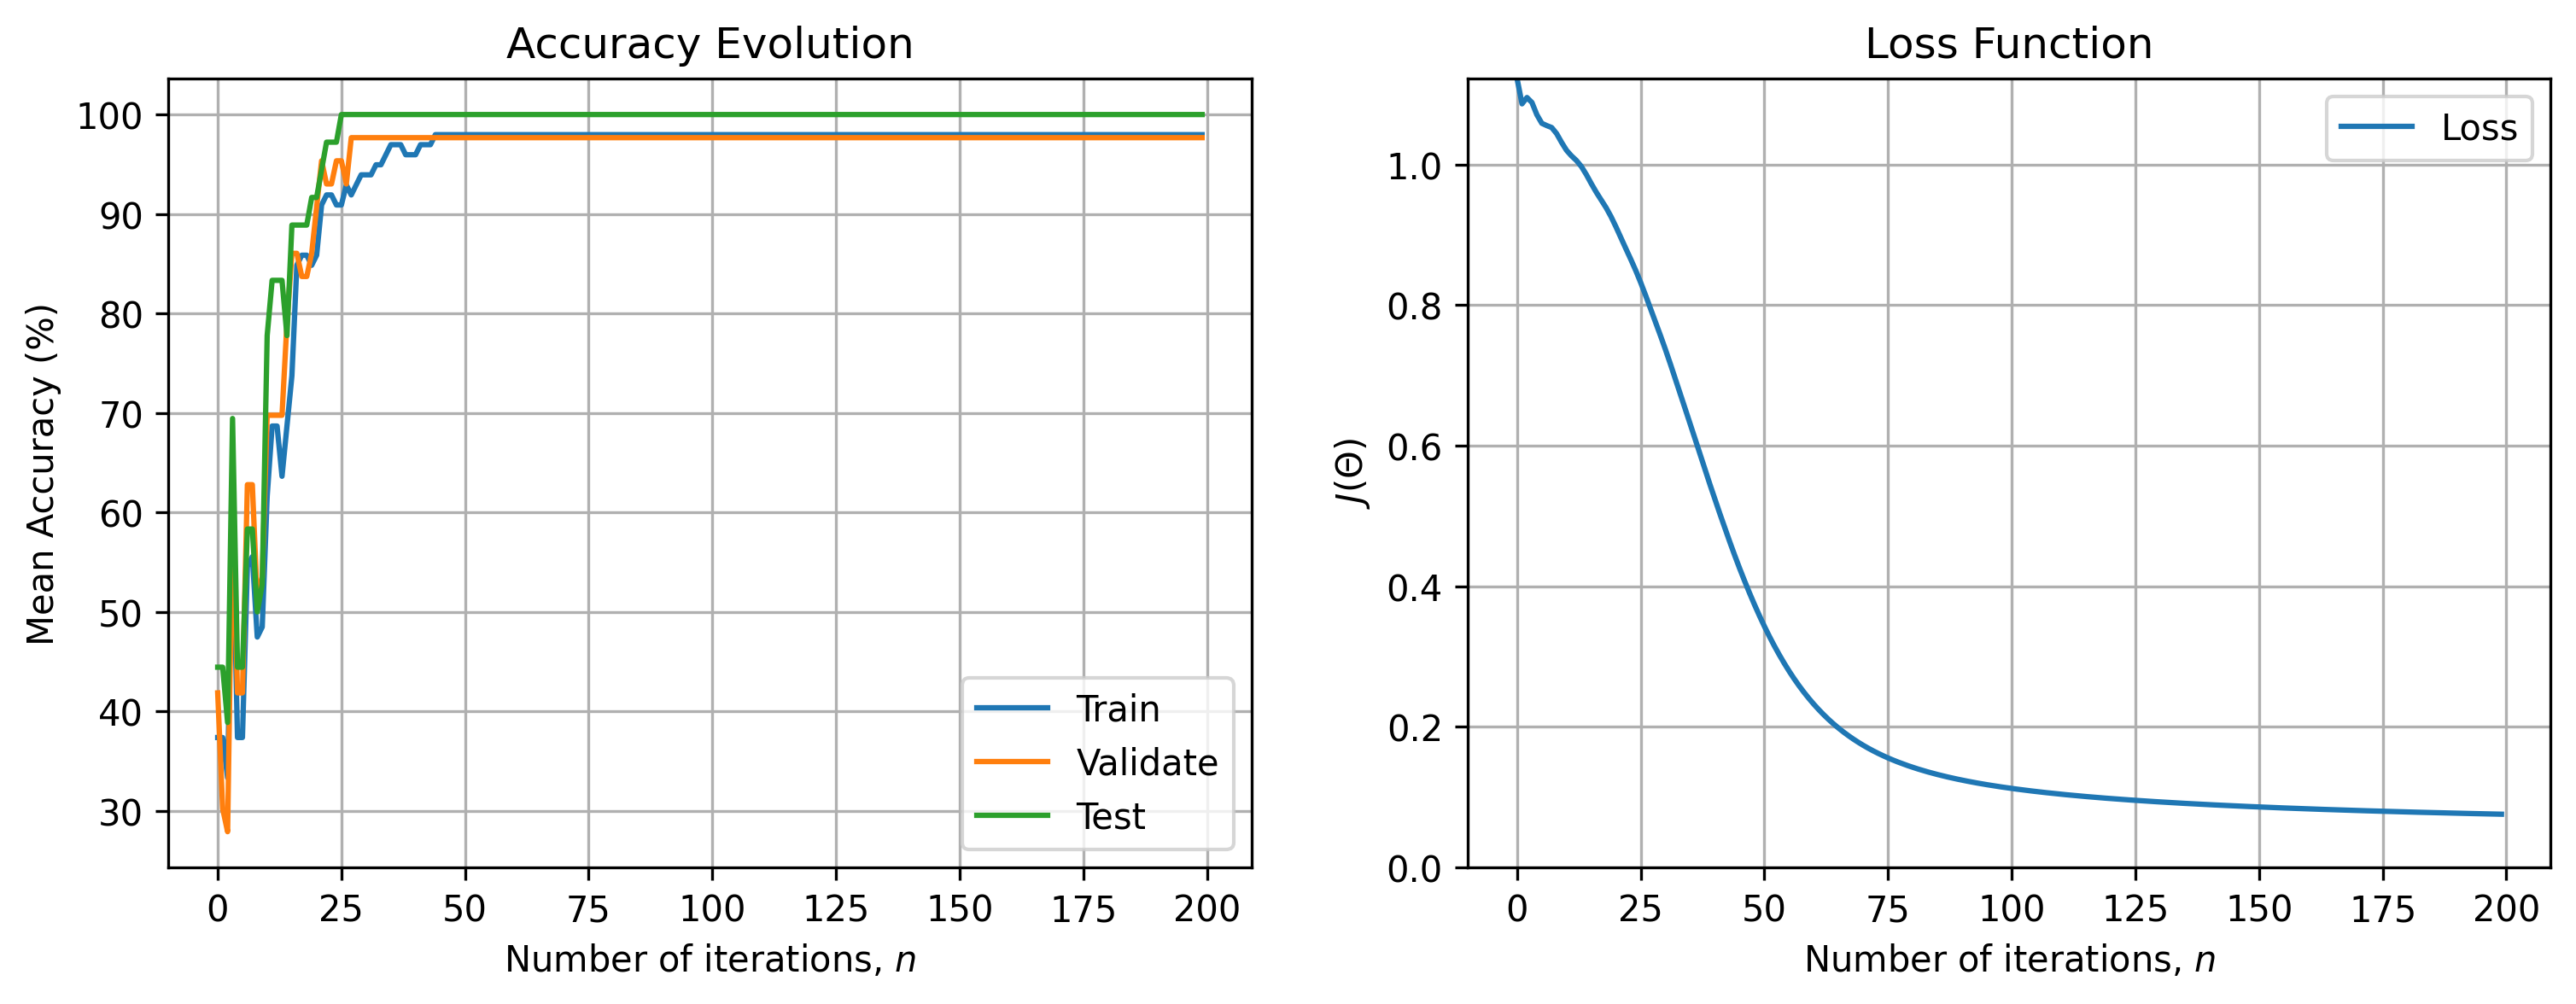

In [33]:
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(np.array(train_score)*100, label = "Train ")
axes[0].plot(np.array(validate_score)*100, label = "Validate")
axes[0].plot(np.array(test_score)*100, label = "Test")

axes[0].set_title("Accuracy Evolution")
axes[0].set_xlabel(r"Number of iterations, $n$")
axes[0].set_ylabel("Mean Accuracy (%)")
# axes[0].set_ylim([0.35, 1.05])
# axes[0].axis("scaled")
# axes[0].set_xlim([0,75])
axes[0].grid(True)
axes[0].legend()

axes[1].plot(myNN.loss_curve_, label = "Loss")
axes[1].set_title("Loss Function")
axes[1].set_xlabel(r"Number of iterations, $n$")
axes[1].set_ylabel(r"$J(\Theta)$")
axes[1].set_ylim([0, myNN.loss_curve_[0]])
axes[1].legend()
axes[1].grid(True)

plt.show()

In [34]:
print(myNN.loss_)

0.07587397520792062


The model's accuarcy changes agressively in the first iterations, and then it increases more smoothly until it stabilizes around 45 iterations. The model consistently performs better on the test set, followed by the accuracy of the validating set, though the latter converges to a very similar performance (97.7%) as the training set (97.9%). This, along with the decision boundary suggests that the model definitely does not overfit, otherwise the training set would perform perfectly, and the validate and test sets would (perhaps) perform considerably worse. We can also say that the model does not underfit since the accuracy is impressively high, and the source of error is believed to be irreducible (for this particular configuration of scaling and PCA).

## Classification Metrics

Taking a look at the specific classification metrics on each subset will elucidate on the performance of the model. Starting with the training set:

### Train

In [35]:
print(classification_report(y_train, myNN.predict(x_train), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       0.94      1.00      0.97        33
      Wine B       1.00      0.95      0.97        37
      Wine C       1.00      1.00      1.00        29

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



All of the average scores are 98%, however, this is not the full story. The precision of the first wine category was considerably lower than the other two, with a 94% in comparison to the perfect score of the latter two. This suggests that Wine A is the hardest to classify positive predictions correctly. In terms of recall, the binary classfier for Wine B performed the worst with 95%, meaning that Wine B is the tougher category to classify in general (true positives and false negatives). Finally, the combination of the two yields a similar score for A and B, whine C obtained a perfect score.

### Validate

In [36]:
print(classification_report(y_validate, myNN.predict(x_validate), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      1.00      1.00        12
      Wine B       1.00      0.94      0.97        18
      Wine C       0.93      1.00      0.96        13

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



In the validating set, some roles flipped. Now Wine C performed worse in terms of precision, and Wine A got a perfect score overall. The rest remained the same. This homogeneity in the results -also obtaining 98% avg in all metrics- suggests that the model generalizes extremely well and, given the very high degree of accuracy, we confirm that the model is niether biased or high in variance.

### Test

In [37]:
print(classification_report(y_test, myNN.predict(x_test), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      1.00      1.00        14
      Wine B       1.00      1.00      1.00        16
      Wine C       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



The results of the test set further confirms what was previously stated, since the model was able to perfectly classify unseen data.

## Confusion Matrices

One can further visualize these metrics in a condensed manner through the confusion matrices of every subset.

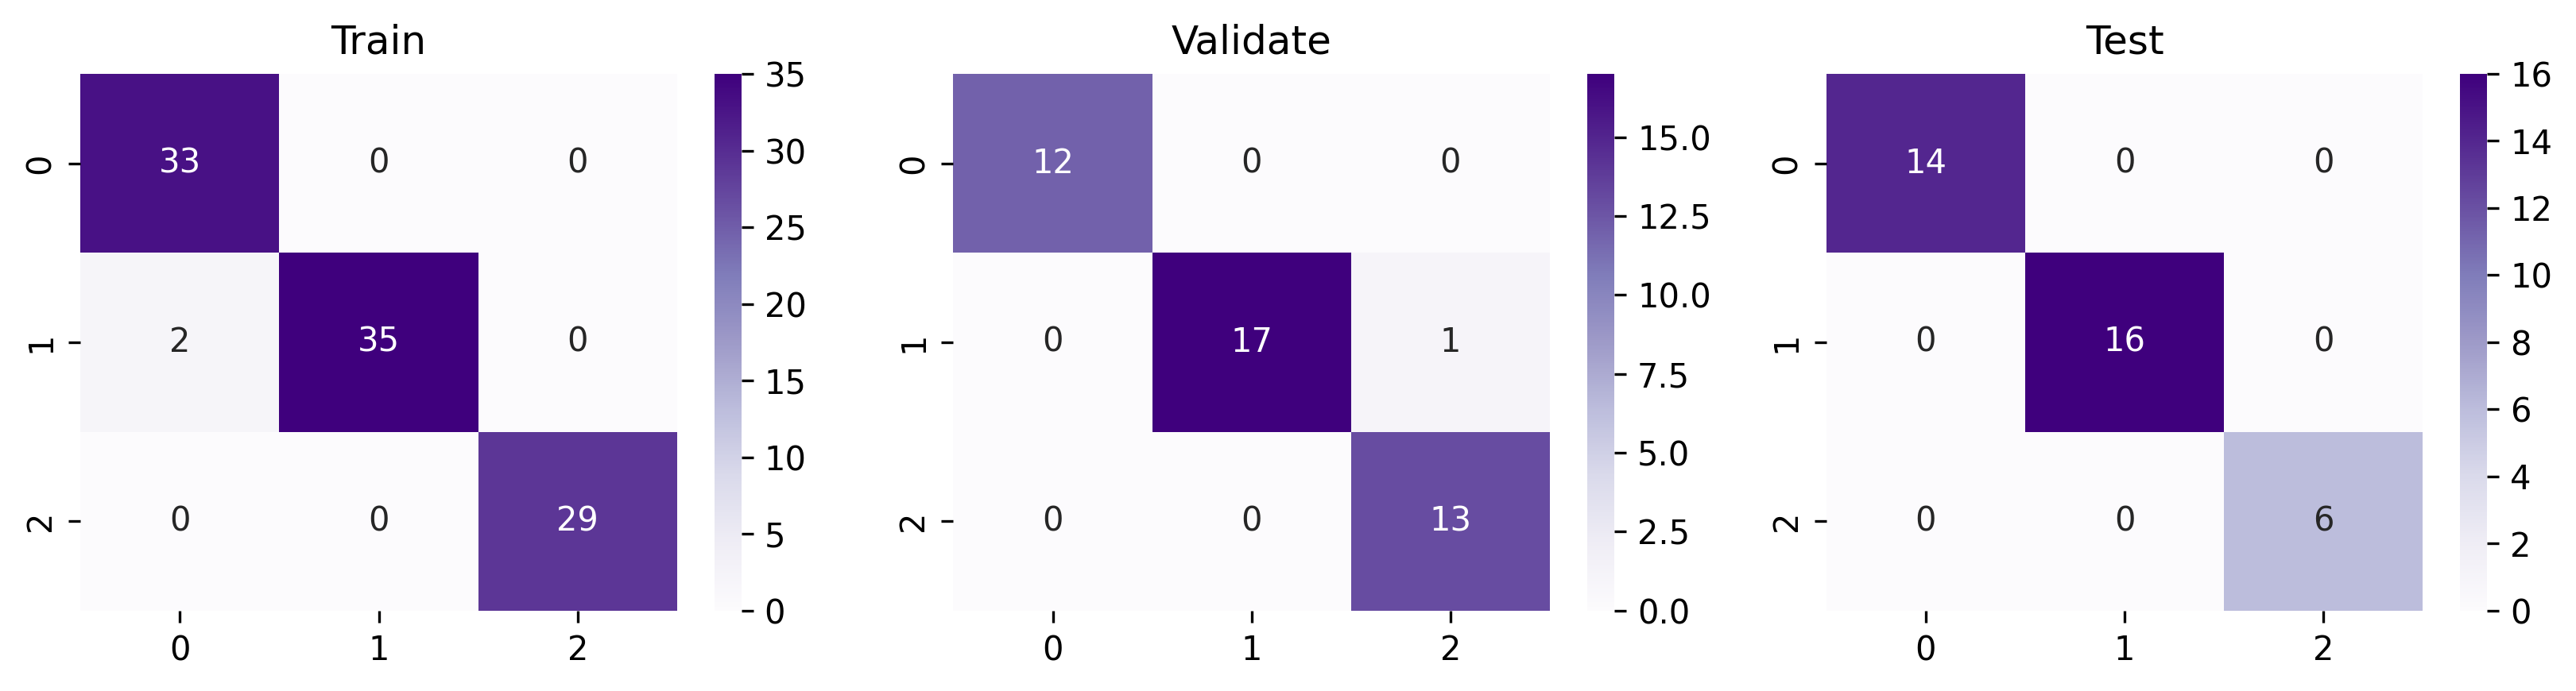

In [38]:
fig, axes = plt.subplots(1, 3, figsize = (11, 3))

sns.heatmap(confusion_matrix(y_train, myNN.predict(x_train)), annot = True, cmap = "Purples", ax = axes[0])
axes[0].set_title("Train")

sns.heatmap(confusion_matrix(y_validate, myNN.predict(x_validate)), annot = True, cmap = "Purples", ax = axes[1])
axes[1].set_title("Validate")

sns.heatmap(confusion_matrix(y_test, myNN.predict(x_test)), annot = True, cmap = "Purples", ax = axes[2])
axes[2].set_title("Test")

plt.tight_layout()
plt.show()

## Regularization

Finally, it is worth testing the L2 regularization strength, $\alpha$, just to make sure we're obtaining the best fit model. We will perform 500 iterations over increasing values of $\alpha$ for our model, and obtain the score each iteration.

In [39]:
train_scoreL2, validate_scoreL2, test_scoreL2 = [], [], []

L2 = np.linspace(0.0, 4, 500)

for l2 in L2:
    
    L2NN = MLPClassifier(random_state = rs, hidden_layer_sizes = (64,), learning_rate = "adaptive", 
                     solver="adam", activation = "logistic", alpha = l2, 
                     learning_rate_init = 0.01, max_iter = epochs)
    
    L2NN.fit(x_train, y_train)
    
    train_scoreL2.append(L2NN.score(x_train, y_train))
    validate_scoreL2.append(L2NN.score(x_validate, y_validate))
    test_scoreL2.append(L2NN.score(x_test, y_test))

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In order to visualize the behavior of the L2 term, we visualize the scores obtained each iteration:

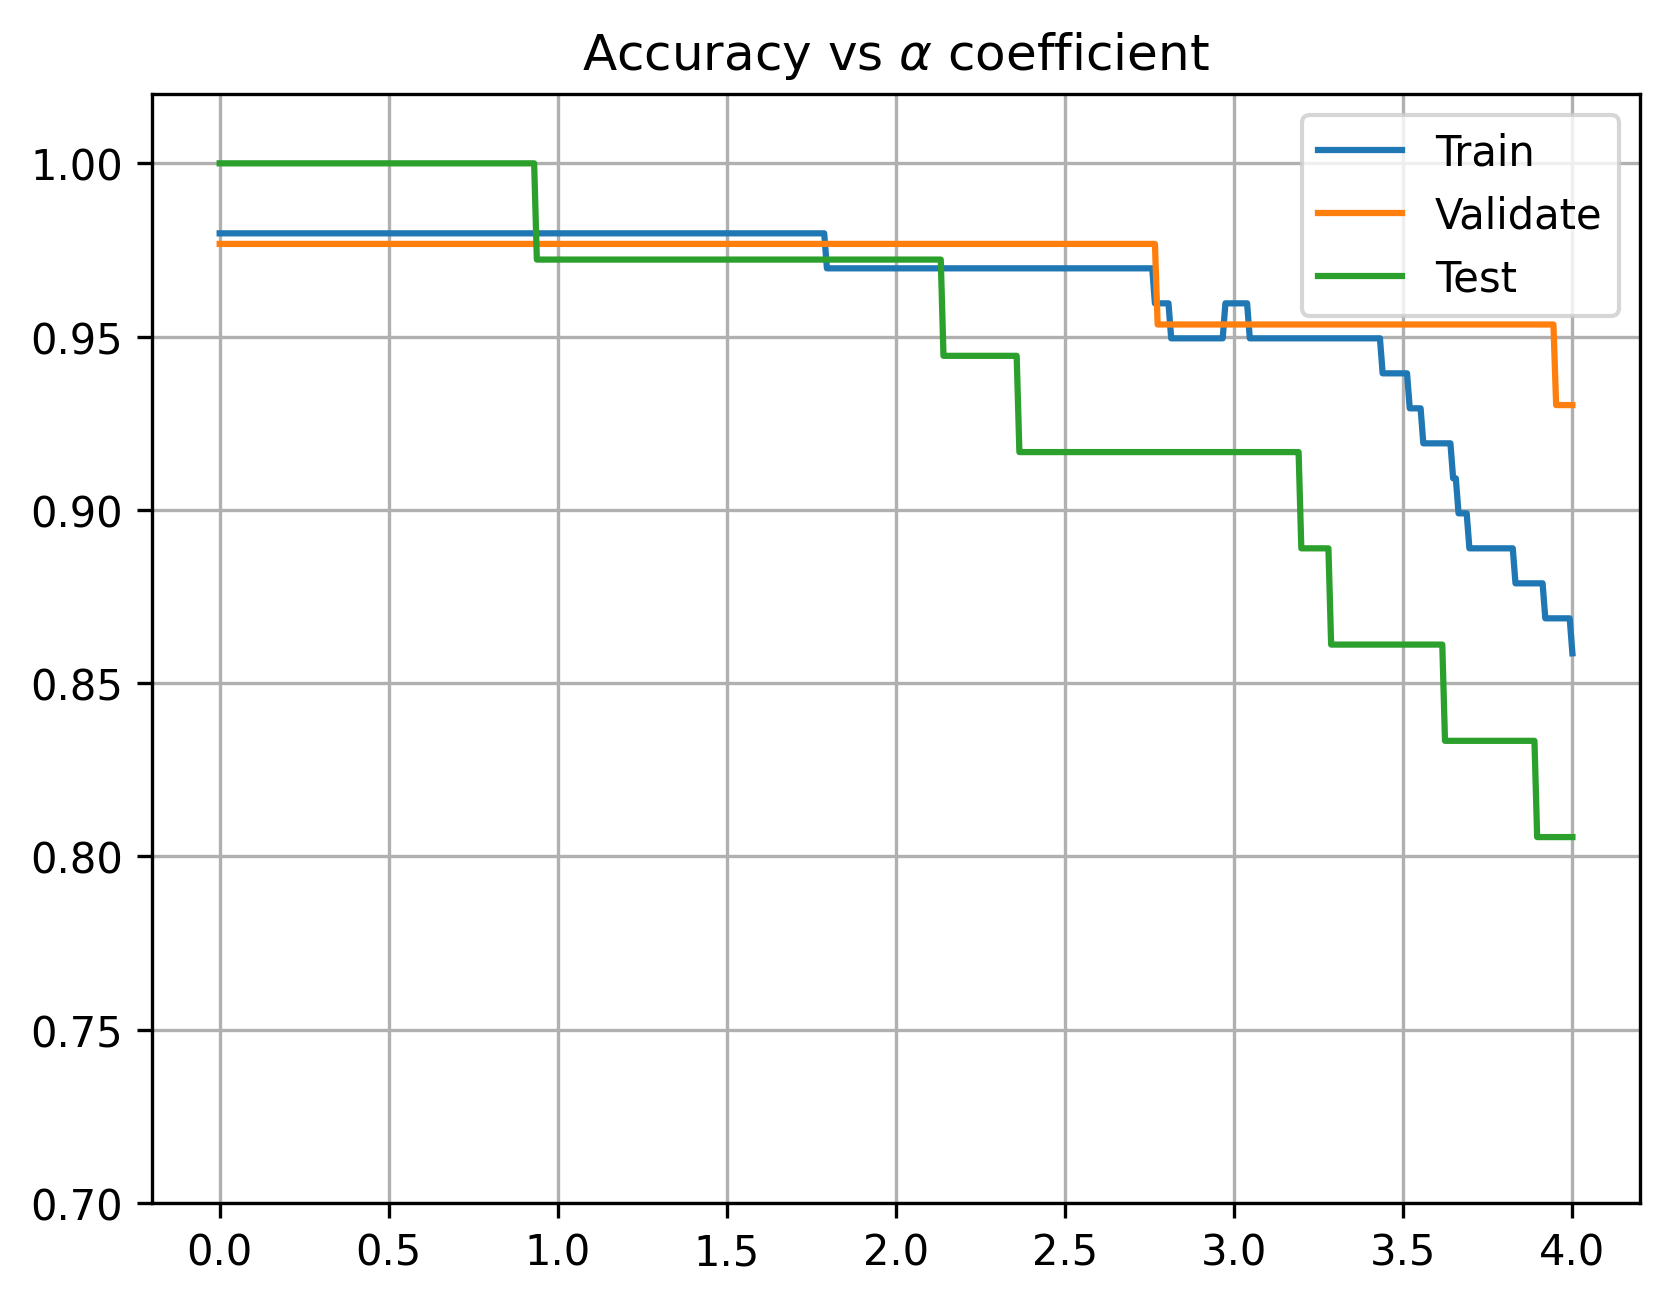

In [40]:
plt.plot(L2, train_scoreL2, label = "Train ")
plt.plot(L2, validate_scoreL2, label = "Validate")
plt.plot(L2, test_scoreL2, label = "Test")
plt.title(r"Accuracy vs $\alpha$ coefficient")
plt.ylim([0.7, 1.02])
plt.grid(True)
plt.legend()
plt.show()

It seems to be the case that increasing the strength of the L2 regularization term ($\alpha$) only worsen the performance of our model (all else hyperparameters equal). Therefore, it is safe to postulate that,

```python
myNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (64,), learning_rate = "adaptive", 
                     solver="adam", activation = "logistic", alpha = 0.0001, 
                     learning_rate_init = 0.01, max_iter = epochs)
```

is an excelent model of classification with the given space (PCA), scaling (MinMax), and constraints (epochs).